In [ ]:
%%bash

# Download Example Data --------------------------------------------------------

rm -rf ./sample_data/

mkdir -p data

rm -f ./data/*

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_test_set.txt >./data/pwm_seq_200bp_test_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_valid_set.txt >./data/pwm_seq_200bp_valid_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_train_set.txt >./data/pwm_seq_200bp_train_set.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   318k      0 --:--:-- --:--:-- --:--:--  318k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   438k      0 --:--:-- --:--:-- --:--:--  439k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7533k  100 7533k    0     0  6273k      0  0:00:01  0:00:01 --:--:-- 6272k


In [ ]:
%%bash

# Create some directories and download helper scripts for later ----------------
mkdir -p helper visualize

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/functions_for_motif_plotting.R >./helper/functions_for_motif_plotting.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_weights_per_dir.R >./helper/plot_sequence_kernel_weights_per_dir.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_icms_per_dir.R >./helper/plot_sequence_kernel_icms_per_dir.R


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18139  100 18139    0     0  46823      0 --:--:-- --:--:-- --:--:-- 46870
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1512  100  1512    0     0   4071      0 --:--:-- --:--:-- --:--:--  4075
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1510  100  1510    0     0   4017      0 --:--:-- --:--:-- --:--:--  4015


In [ ]:
%%bash

# Check Data Layout ###########################

# check lines per set
echo "Numbers:"
wc -l ./data/pwm*

# check data format
echo -ne "\nFormat\n"
head -n 3 ./data/pwm_seq_200bp_test_set.txt

# check class representation
echo -ne "\nClass Representations:\n"

echo -ne "\nTraining:\n"
cut -f 1 ./data/pwm_seq_200bp_train_set.txt | sort | uniq -c
echo -ne "\nTest:\n"
cut -f 1 ./data/pwm_seq_200bp_test_set.txt | sort | uniq -c
echo -ne "\nValidation:\n"
cut -f 1 ./data/pwm_seq_200bp_valid_set.txt | sort | uniq -c



Numbers:
   1000 ./data/pwm_seq_200bp_test_set.txt
  38000 ./data/pwm_seq_200bp_train_set.txt
   1000 ./data/pwm_seq_200bp_valid_set.txt
  40000 total

Format
3	ATGGCTGATAATGACGATTGTACAGATGGTGGATGAGATTGCCTCGTCCCGGCAGCATTACCCCCTGGTGGCAACGGCCACCAGGGGGCAATAAATCTGTGTCTTATCTCCGAGACCAAACAATTCCACAGCCTCTTATACAGCACCGAATGGACCGCCCCCTGGTGGCCAGGTATCGTCGAGGGCTCAATTAAACTCCT
1	GCAGGCATTATGAGGTAATAAACTCAGCGCGTGTTGAGATAAGATTCTAAGCGGCGCGCGCGCGCGACCGCGAGAAGTGGAGATTAAGCGCGCTAATGGTGTGTCCGATAGTCACGTGTCCGCGCGGCGCGCGCCATGTATGTTCTGTTCTGCGCGCCGCGCTTTGCGCGCGCGCTTGGTATATAAAGCTGGGTTTTAAT
1	GGCGCGCCTGGCATTTCTTAGAGAGGCGCGCAATACAACGAGAATCACCTAGAAGCCGTGTCTGTTGCTTATCACCGTTCGCCTAGGCCGCACGGGCACGTGGGTCTCCCGTTCCCTCAATCCTAACAGAAGCGCGCTAAGTCGTCGTTGGCTCTCTTACTAGCAGCGCGCCTGTACTAACCCGGCACTCGGCGGTGGGC

Class Representations:

Training:
   9489 0
   9513 1
   9508 2
   9490 3

Test:
    268 0
    237 1
    243 2
    252 3

Validation:
    243 0
    250 1
    249 2
    258 3


In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
def encode_sequence(seq):
    return [nucleotide_map[nuc] for nuc in seq if nuc in nucleotide_map]

def load_data(filepath):
    data = pd.read_csv(filepath, sep="\t", header=None, names=["label", "sequence"])
    data["encoded"] = data["sequence"].apply(encode_sequence)
    return data

def train_hmm_per_label(train_data, n_states=4):
    label_hmms = {}
    for label in sorted(train_data['label'].unique()):
        label_data = train_data[train_data['label'] == label]
        sequences = label_data['encoded'].tolist()
        lengths = [len(seq) for seq in sequences]
        X = np.concatenate([np.array(seq) for seq in sequences]).reshape(-1, 1)

        model = hmm.CategoricalHMM(n_components=n_states, n_iter=100, tol=1e-5, init_params='ste',algorithm='map')
        model.fit(X, lengths)
        label_hmms[label] = model
    return label_hmms

def predict_labels(hmm_models, data):
    predictions = []
    for seq in data['encoded']:
        seq_array = np.array(seq).reshape(-1, 1)
        scores = {label: model.score(seq_array) for label, model in hmm_models.items()}
        pred_label = max(scores, key=scores.get)
        predictions.append(pred_label)
    return predictions

In [ ]:
def evaluate(true_labels, pred_labels, set_name="Test"):
    print(f"\n--- {set_name} Set Evaluation ---")
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
    print("Classification Report:\n", classification_report(true_labels, pred_labels))


In [ ]:
nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [ ]:
# Load data
train = load_data("/content/data/pwm_seq_200bp_train_set.txt")
test = load_data("/content/data/pwm_seq_200bp_test_set.txt")
valid = load_data("/content/data/pwm_seq_200bp_valid_set.txt")


In [ ]:
# Train HMMs
hmm_models = train_hmm_per_label(train, n_states=4)

In [ ]:
hmm_models[1].startprob_, hmm_models[1].emissionprob_ , hmm_models[1].transmat_

(array([0.0025721 , 0.10742995, 0.83907443, 0.05092353]),
 array([[3.06149637e-04, 9.87795750e-01, 5.74784360e-04, 1.13233165e-02],
        [1.99022456e-01, 5.31275408e-01, 6.74566663e-02, 2.02245470e-01],
        [2.64284016e-01, 2.28807455e-01, 2.42538592e-01, 2.64369937e-01],
        [1.52993193e-02, 1.13428960e-04, 9.83631013e-01, 9.56238440e-04]]),
 array([[1.25885280e-02, 5.32889151e-02, 3.12254232e-01, 6.21868325e-01],
        [1.20935401e-05, 3.80740360e-01, 5.05670640e-01, 1.13576907e-01],
        [2.75352917e-03, 1.54324202e-02, 9.43241307e-01, 3.85727440e-02],
        [8.88067862e-01, 7.40187949e-02, 1.51060481e-02, 2.28072949e-02]]))

In [ ]:

hmm_models[0].startprob_, hmm_models[0].emissionprob_ , hmm_models[0].transmat_

(array([0.07211919, 0.83908356, 0.00975971, 0.07903754]),
 array([[7.61627831e-04, 6.78701931e-04, 9.97690751e-01, 8.68918801e-04],
        [2.64383669e-01, 2.40573659e-01, 2.30793209e-01, 2.64249463e-01],
        [2.59229677e-04, 9.99259873e-01, 1.03229082e-04, 3.77667811e-04],
        [2.59255221e-01, 1.75186203e-01, 3.12512520e-01, 2.53046056e-01]]),
 array([[3.27829791e-02, 9.39416272e-03, 9.57773152e-01, 4.97057352e-05],
        [5.54371331e-02, 8.49450033e-01, 1.87863907e-04, 9.49249699e-02],
        [6.54336638e-01, 2.94286498e-01, 3.43117106e-02, 1.70651536e-02],
        [3.24526634e-01, 6.17060676e-01, 5.31481698e-02, 5.26452018e-03]]))

In [ ]:
hmm_models[2].startprob_, hmm_models[2].emissionprob_ , hmm_models[2].transmat_

(array([0.91541639, 0.01695774, 0.02951272, 0.03811315]),
 array([[2.19821037e-01, 2.79913086e-01, 2.79433692e-01, 2.20832185e-01],
        [7.65302319e-08, 3.75693162e-03, 2.84165283e-03, 9.93401339e-01],
        [9.96706154e-01, 1.69333356e-03, 1.52497504e-03, 7.55369674e-05],
        [9.25596862e-01, 2.45481449e-03, 3.98899142e-03, 6.79593324e-02]]),
 array([[9.57529825e-01, 4.90661670e-03, 1.67243296e-02, 2.08392286e-02],
        [3.77649533e-01, 1.81048863e-02, 6.04185139e-01, 6.04423525e-05],
        [3.24449011e-02, 9.37597059e-01, 2.06439133e-12, 2.99580395e-02],
        [1.36923813e-01, 7.33519852e-01, 1.82870981e-07, 1.29556152e-01]]))

In [ ]:
hmm_models[3].startprob_, hmm_models[3].emissionprob_ , hmm_models[3].transmat_

(array([2.71500588e-01, 1.91131202e-01, 2.31641268e-06, 5.37365894e-01]),
 array([[0.18490707, 0.221647  , 0.19923978, 0.39420615],
        [0.30656209, 0.4116794 , 0.12815142, 0.15360709],
        [0.04658784, 0.5584532 , 0.24100294, 0.15395602],
        [0.27406408, 0.18204282, 0.32373777, 0.22015533]]),
 array([[2.92133232e-01, 4.36837517e-01, 1.50846456e-06, 2.71027743e-01],
        [9.47270545e-01, 5.74068391e-03, 2.47006856e-02, 2.22880860e-02],
        [1.05791854e-02, 6.90329077e-01, 3.47249439e-08, 2.99091703e-01],
        [1.72248288e-03, 4.63775259e-02, 1.16075857e-01, 8.35824134e-01]]))

In [ ]:
# Predict
test_preds = predict_labels(hmm_models, test)
valid_preds = predict_labels(hmm_models, valid)

In [ ]:
# Evaluate
evaluate(test['label'], test_preds, "Test")
evaluate(valid['label'], valid_preds, "Validation")


--- Test Set Evaluation ---
Accuracy: 0.903
Confusion Matrix:
 [[219  49   0   0]
 [ 24 209   0   4]
 [  0   0 236   7]
 [  0   7   6 239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       268
           1       0.79      0.88      0.83       237
           2       0.98      0.97      0.97       243
           3       0.96      0.95      0.95       252

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000


--- Validation Set Evaluation ---
Accuracy: 0.901
Confusion Matrix:
 [[198  45   0   0]
 [ 25 219   1   5]
 [  0   1 244   4]
 [  0  11   7 240]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85       243
           1       0.79      0.88      0.83       250
           2       0.97      0.98      0.97       249
           3

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load sequences and labels
def load_data(filepath):
    sequences, labels = [], []
    with open(filepath, 'r') as f:
        for line in f:
            label, seq = line.strip().split('\t')
            sequences.append(seq)
            labels.append(int(label))
    return sequences, labels

def one_hot_encode(seq, seq_len=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((seq_len, 4))
    for i, base in enumerate(seq):
        if base in mapping:
            one_hot[i, mapping[base]] = 1
    return one_hot

train_sequences, train_labels = load_data("/content/data/pwm_seq_200bp_train_set.txt")
test_sequences, test_labels = load_data("/content/data/pwm_seq_200bp_test_set.txt")

X_train = np.array([one_hot_encode(seq) for seq in train_sequences])
X_test = np.array([one_hot_encode(seq) for seq in test_sequences])
y_train = to_categorical(train_labels, num_classes=4)
y_test = to_categorical(test_labels, num_classes=4)

# CNN Model
model = Sequential([
    Conv1D(64, 10, activation='relu', input_shape=(200, 4)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),
    Conv1D(128, 10, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

# Evaluate
preds = model.predict(X_test)
y_pred_cnn = np.argmax(preds, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)
print("\nCNN Classification Report:\n")
print(classification_report(y_true_cnn, y_pred_cnn))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.6172 - loss: 0.8210 - val_accuracy: 0.8803 - val_loss: 0.2860
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.8847 - loss: 0.2769 - val_accuracy: 0.9284 - val_loss: 0.1822
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.9346 - loss: 0.1713 - val_accuracy: 0.9687 - val_loss: 0.0849
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - accuracy: 0.9627 - loss: 0.1038 - val_accuracy: 0.9763 - val_loss: 0.0650
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9730 - loss: 0.0752 - val_accuracy: 0.9813 - val_loss: 0.0526
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.9784 - loss: 0.0617 - val_accuracy: 0.9845 - val_loss: 0.0435
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9833 - loss: 0.0495 - val_accuracy: 0.9855 - val_loss: 0.0380
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9852 - loss: 0

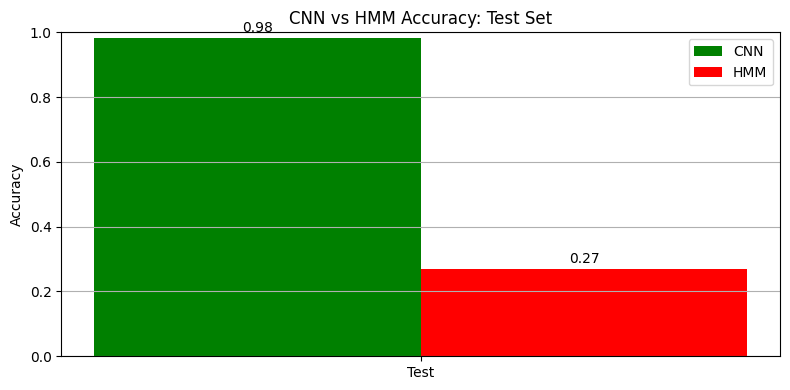

In [ ]:
#comparing model performance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# HMM Accuracies (based on test and valid dataframes)
hmm_test_accuracy = accuracy_score(test['label'], test_preds)
hmm_valid_accuracy = accuracy_score(valid['label'], valid_preds)

# CNN Accuracies (from earlier code)
cnn_test_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)

# Plot
labels = ['Test']
x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar([i - width/2 for i in x], [cnn_test_accuracy], width=width, label='CNN', color='green')
plt.bar([i + width/2 for i in x], [hmm_test_accuracy], width=width, label='HMM', color='red')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('CNN vs HMM Accuracy: Test Set')
plt.legend()

# Annotate
for i, (c_acc, h_acc) in enumerate(zip([cnn_test_accuracy], [hmm_test_accuracy])):
    plt.text(i - width/2, c_acc + 0.02, f'{c_acc:.2f}', ha='center')
    plt.text(i + width/2, h_acc + 0.02, f'{h_acc:.2f}', ha='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
cm_cnn_df = pd.DataFrame(cm_cnn, index=[f"True {i}" for i in range(4)],
                         columns=[f"Pred {i}" for i in range(4)])
print(" CNN Confusion Matrix:")
print(cm_cnn_df)

# HMM Confusion Matrix
cm_hmm = confusion_matrix(test['label'], test_preds)
cm_hmm_df = pd.DataFrame(cm_hmm, index=[f"True {i}" for i in range(4)],
                         columns=[f"Pred {i}" for i in range(4)])
print("\n HMM Confusion Matrix:")
print(cm_hmm_df)


 CNN Confusion Matrix:
        Pred 0  Pred 1  Pred 2  Pred 3
True 0     258      10       0       0
True 1       1     235       0       1
True 2       0       0     243       0
True 3       0       3       3     246

 HMM Confusion Matrix:
        Pred 0  Pred 1  Pred 2  Pred 3
True 0     268       0       0       0
True 1     237       0       0       0
True 2     243       0       0       0
True 3     252       0       0       0
